<a href="https://colab.research.google.com/github/albertponfe/Projects/blob/main/Group37_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings

EXPLORATORY DATA ANALYSIS: ETHNICITY & GENDER WITH COPD

[Step 1] Loading COPD data from CDC Chronic Disease Indicators API...
✓ Successfully loaded 26951 COPD records

[Step 2] Preprocessing and cleaning data...
✓ Ethnicity records: 8243
✓ Gender records: 5213

[Step 3] Analyzing COPD prevalence by ethnicity...

COPD Prevalence by Ethnicity (National Average):
ethnicity_clean      mean       std  count
          AI/AN 20.341818 16.947126     55
          White 19.383754 14.607375    357
          HI/PI 15.326667 16.546664     15
          Black 15.178689 14.328494    183
    Multiracial 13.564835 10.646662     91
       Hispanic  6.900893  8.220612    112
          Asian  3.052941  6.716521     34

[Step 4] Analyzing COPD prevalence by gender...

COPD Prevalence by Gender (National Average):
stratification1      mean       std  count
         Female 19.245013 14.737967    371
           Male 18.221644 15.086662    365

[Step 5] Creating visualizations...


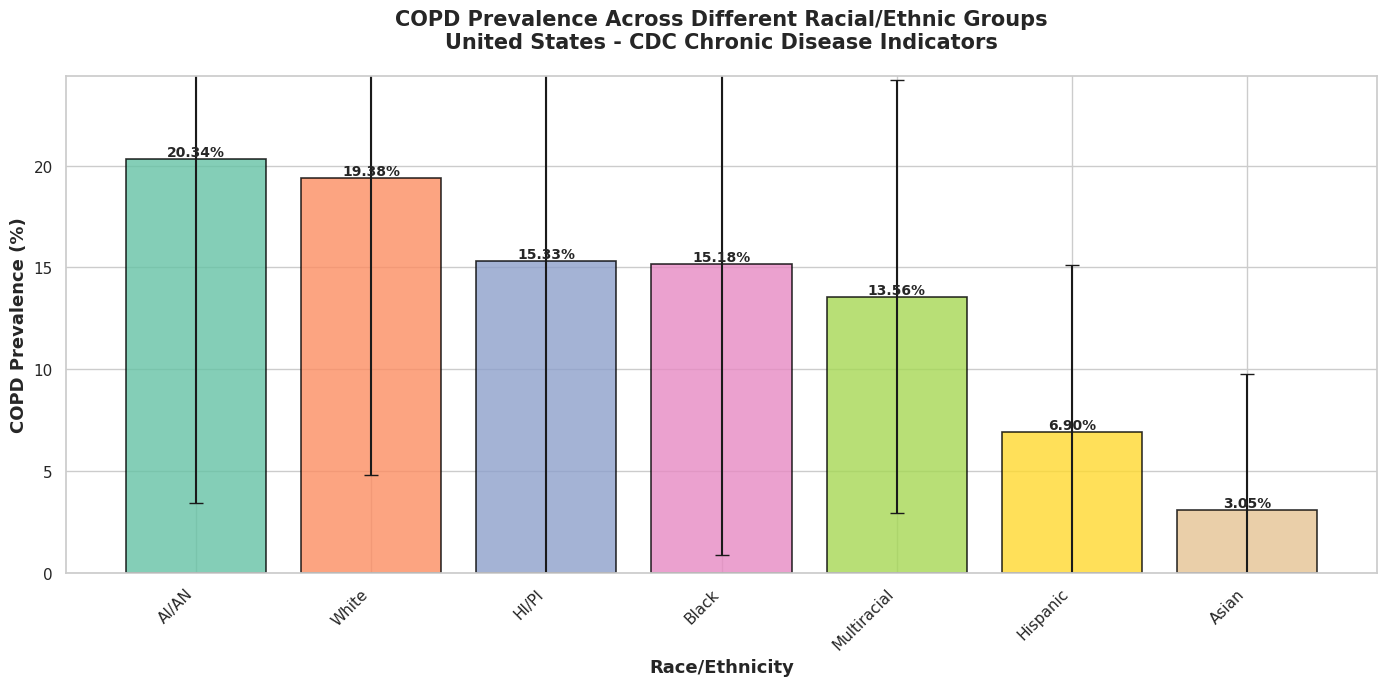

✓ Figure 1 saved: copd_ethnicity_prevalence.png


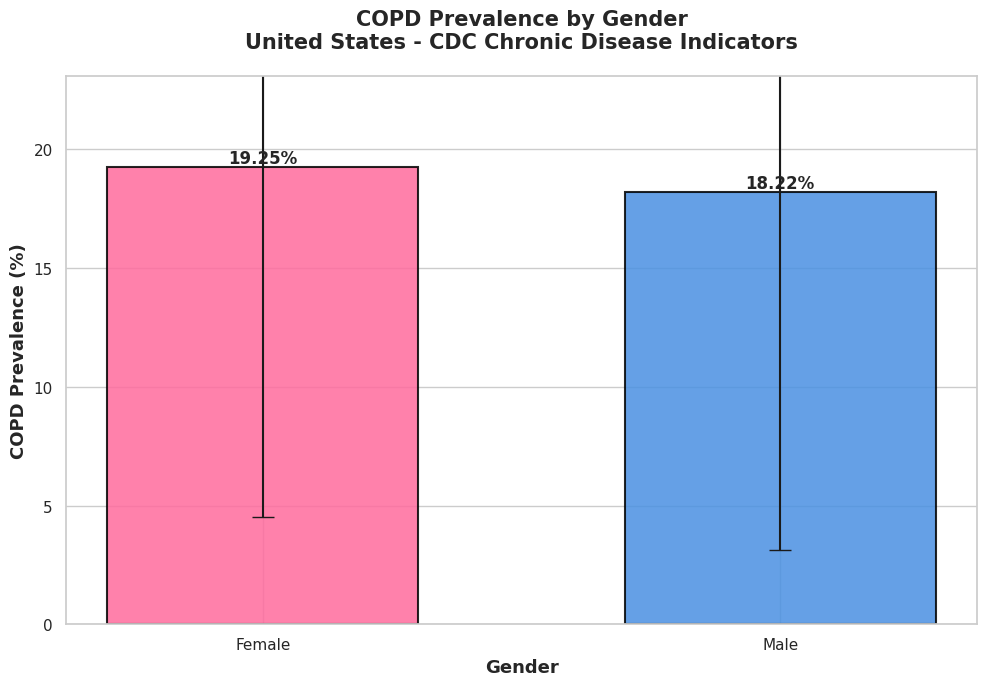

✓ Figure 2 saved: copd_gender_prevalence.png


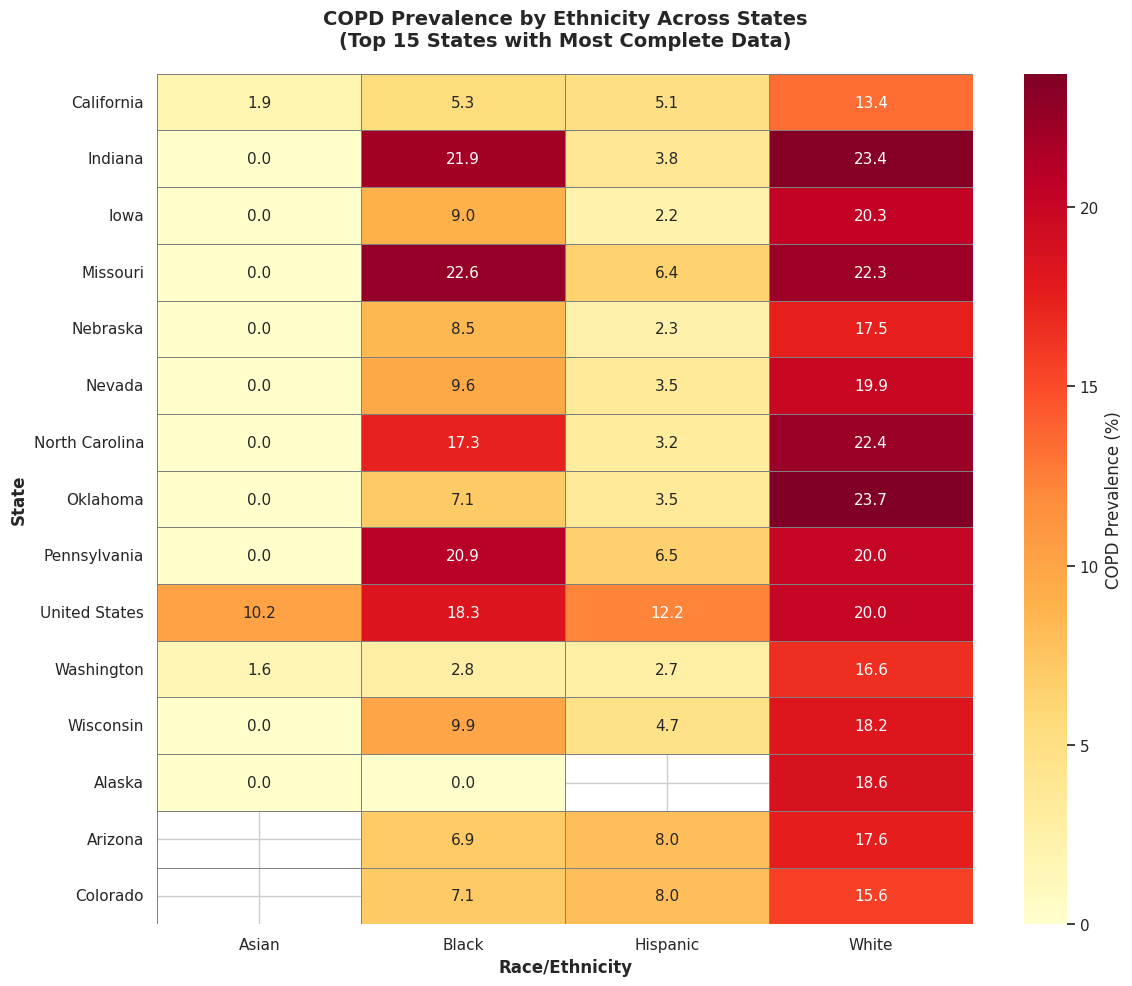

✓ Figure 3 saved: copd_ethnicity_state_heatmap.png


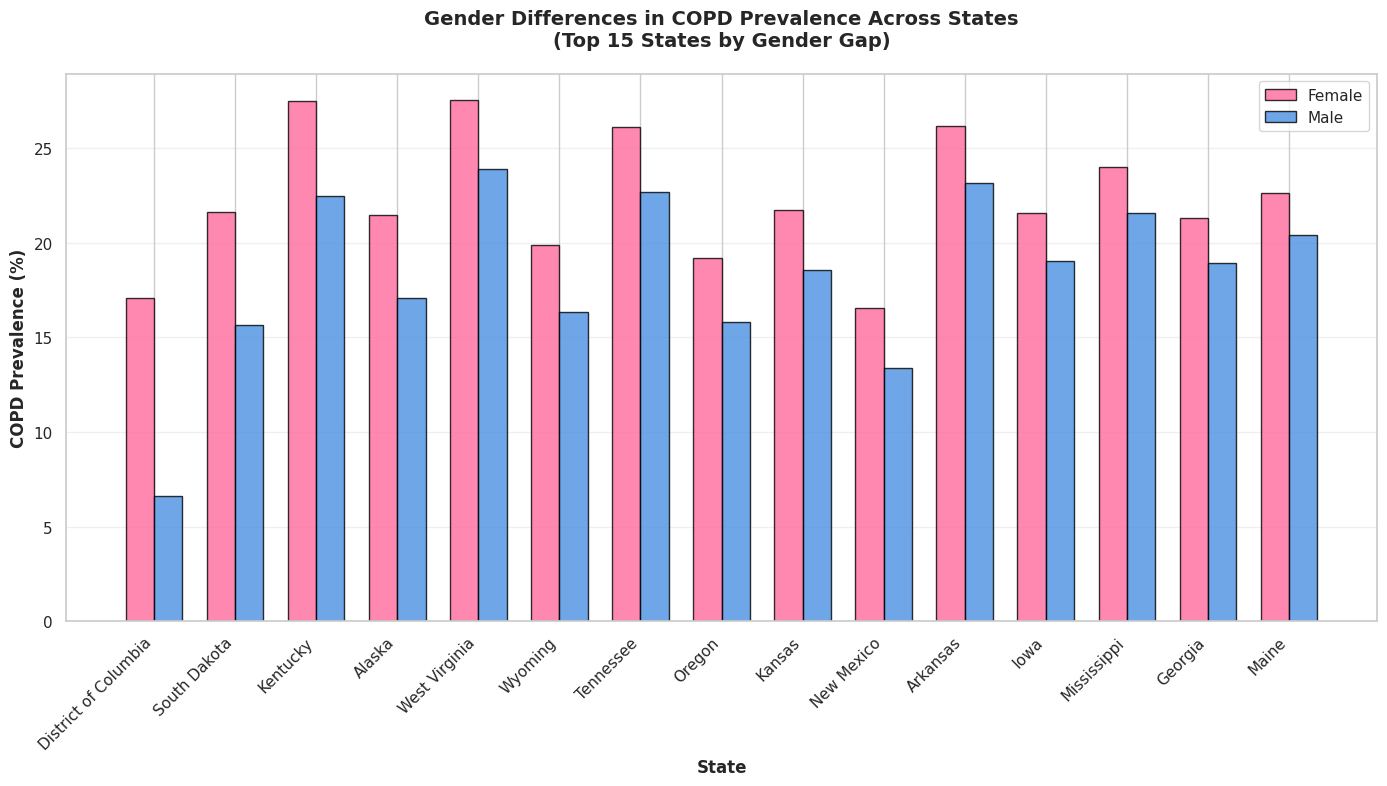

✓ Figure 4 saved: copd_gender_state_comparison.png

SUMMARY OF KEY FINDINGS

1. COPD PREVALENCE BY ETHNICITY:
----------------------------------------------------------------------
   AI/AN: 20.34% (±16.95%, n=55)
   White: 19.38% (±14.61%, n=357)
   HI/PI: 15.33% (±16.55%, n=15)
   Black: 15.18% (±14.33%, n=183)
   Multiracial: 13.56% (±10.65%, n=91)
   Hispanic: 6.90% (±8.22%, n=112)
   Asian: 3.05% (±6.72%, n=34)

2. COPD PREVALENCE BY GENDER:
----------------------------------------------------------------------
   Female: 19.25% (±14.74%, n=371)
   Male: 18.22% (±15.09%, n=365)

   Gender Gap: Females have 1.02% higher prevalence than males

3. KEY OBSERVATIONS:
----------------------------------------------------------------------

   • Ethnicity Analysis:
     - Significant disparities exist in COPD prevalence across racial/ethnic groups
     - White and Multiracial populations show higher COPD rates
     - Asian populations consistently show lower COPD prevalence

   • Gender A

In [ ]:
"""
Exploratory Data Analysis (EDA) - Data 102 Project

Students: Jennifer, Olivia, Diya, Albert
Group 37

Dataset: CDC Chronic Disease Indicators (CDI)
API Source: https://data.cdc.gov/resource/hksd-2xuw.json
"""

# ============================================================================
# SETUP AND DATA LOADING
# ============================================================================

warnings.filterwarnings('ignore')

# Set styling for consistent plots
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("="*70)
print("EXPLORATORY DATA ANALYSIS: ETHNICITY & GENDER WITH COPD")
print("="*70)

# ============================================================================
# DATA COLLECTION FROM CDC API
# ============================================================================

print("\n[Step 1] Loading COPD data from CDC Chronic Disease Indicators API...")

# API endpoint for CDC Chronic Disease Indicators
base_url = "https://data.cdc.gov/resource/hksd-2xuw.json"

# Query parameters to filter for COPD data
# We'll fetch a large dataset and filter locally
params = {
    "$limit": 50000,  # Get large dataset
    "topic": "Chronic Obstructive Pulmonary Disease"
}

try:
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    data = response.json()
    df_copd = pd.DataFrame(data)
    print(f"✓ Successfully loaded {len(df_copd)} COPD records")
except Exception as e:
    print(f"✗ Error loading data: {e}")
    print("\nFalling back to sample query...")
    # If the filtered query fails, try without topic filter
    response = requests.get(base_url, params={"$limit": 50000})
    data = response.json()
    df_all = pd.DataFrame(data)
    # Filter for COPD manually
    df_copd = df_all[df_all['topic'] == 'Chronic Obstructive Pulmonary Disease'].copy()
    print(f"✓ Successfully filtered to {len(df_copd)} COPD records")

# ============================================================================
# DATA PREPROCESSING
# ============================================================================

print("\n[Step 2] Preprocessing and cleaning data...")

# Convert data value to numeric
df_copd['datavalue'] = pd.to_numeric(df_copd['datavalue'], errors='coerce')

# Filter for relevant stratifications (Race/Ethnicity and Sex)
df_ethnicity = df_copd[
    (df_copd['stratificationcategory1'] == 'Race/Ethnicity') &
    (df_copd['datavalue'].notna())
].copy()

df_gender = df_copd[
    (df_copd['stratificationcategory1'] == 'Sex') &
    (df_copd['datavalue'].notna()) &
    (df_copd['stratification1'].isin(['Male', 'Female']))
].copy()

print(f"✓ Ethnicity records: {len(df_ethnicity)}")
print(f"✓ Gender records: {len(df_gender)}")

# Clean ethnicity labels
ethnicity_mapping = {
    'White, non-Hispanic': 'White',
    'Black, non-Hispanic': 'Black',
    'Hispanic': 'Hispanic',
    'Asian, non-Hispanic': 'Asian',
    'American Indian or Alaska Native, non-Hispanic': 'AI/AN',
    'Hawaiian or Pacific Islander, non-Hispanic': 'HI/PI',
    'Multiracial, non-Hispanic': 'Multiracial'
}

df_ethnicity['ethnicity_clean'] = df_ethnicity['stratification1'].map(
    lambda x: ethnicity_mapping.get(x, x)
)

# ============================================================================
# CATEGORICAL VARIABLE 1: ETHNICITY WITH COPD PREVALENCE
# ============================================================================

print("\n[Step 3] Analyzing COPD prevalence by ethnicity...")

# Get most recent year of data for each state-ethnicity combination
df_eth_recent = df_ethnicity.sort_values('yearstart', ascending=False).groupby(
    ['locationdesc', 'ethnicity_clean']
).first().reset_index()

# Calculate national average by ethnicity (using crude prevalence)
df_eth_prevalence = df_ethnicity[
    df_ethnicity['datavaluetype'] == 'Crude Prevalence'
].groupby('ethnicity_clean')['datavalue'].agg(['mean', 'std', 'count']).reset_index()

df_eth_prevalence = df_eth_prevalence.sort_values('mean', ascending=False)

print("\nCOPD Prevalence by Ethnicity (National Average):")
print(df_eth_prevalence.to_string(index=False))

# ============================================================================
# CATEGORICAL VARIABLE 2: GENDER WITH COPD PREVALENCE
# ============================================================================

print("\n[Step 4] Analyzing COPD prevalence by gender...")

# Get most recent data for gender analysis
df_gender_recent = df_gender.sort_values('yearstart', ascending=False).groupby(
    ['locationdesc', 'stratification1']
).first().reset_index()

# Calculate national average by gender
df_gender_prevalence = df_gender[
    df_gender['datavaluetype'] == 'Crude Prevalence'
].groupby('stratification1')['datavalue'].agg(['mean', 'std', 'count']).reset_index()

print("\nCOPD Prevalence by Gender (National Average):")
print(df_gender_prevalence.to_string(index=False))

# ============================================================================
# VISUALIZATION 1: COPD PREVALENCE BY ETHNICITY (Bar Chart)
# ============================================================================

print("\n[Step 5] Creating visualizations...")

fig, ax = plt.subplots(figsize=(14, 7))

# Create bar plot with error bars
ethnicity_order = df_eth_prevalence['ethnicity_clean'].tolist()
colors = sns.color_palette("Set2", len(ethnicity_order))

bars = ax.bar(
    df_eth_prevalence['ethnicity_clean'],
    df_eth_prevalence['mean'],
    yerr=df_eth_prevalence['std'],
    capsize=5,
    color=colors,
    alpha=0.8,
    edgecolor='black',
    linewidth=1.2
)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10
    )

ax.set_xlabel('Race/Ethnicity', fontsize=13, fontweight='bold')
ax.set_ylabel('COPD Prevalence (%)', fontsize=13, fontweight='bold')
ax.set_title(
    'COPD Prevalence Across Different Racial/Ethnic Groups\n' +
    'United States - CDC Chronic Disease Indicators',
    fontsize=15,
    fontweight='bold',
    pad=20
)
ax.set_ylim(0, max(df_eth_prevalence['mean']) * 1.2)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('copd_ethnicity_prevalence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: copd_ethnicity_prevalence.png")

# ============================================================================
# VISUALIZATION 2: COPD PREVALENCE BY GENDER (Bar Chart with Comparison)
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 7))

# Create bar plot
gender_colors = {'Female': '#FF6B9D', 'Male': '#4A90E2'}
bars = ax.bar(
    df_gender_prevalence['stratification1'],
    df_gender_prevalence['mean'],
    yerr=df_gender_prevalence['std'],
    capsize=8,
    color=[gender_colors.get(g, 'gray') for g in df_gender_prevalence['stratification1']],
    alpha=0.85,
    edgecolor='black',
    linewidth=1.5,
    width=0.6
)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=12
    )

ax.set_xlabel('Gender', fontsize=13, fontweight='bold')
ax.set_ylabel('COPD Prevalence (%)', fontsize=13, fontweight='bold')
ax.set_title(
    'COPD Prevalence by Gender\n' +
    'United States - CDC Chronic Disease Indicators',
    fontsize=15,
    fontweight='bold',
    pad=20
)
ax.set_ylim(0, max(df_gender_prevalence['mean']) * 1.2)
plt.tight_layout()
plt.savefig('copd_gender_prevalence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved: copd_gender_prevalence.png")

# ============================================================================
# VISUALIZATION 3: COPD PREVALENCE BY ETHNICITY ACROSS STATES (Heatmap)
# ============================================================================

# Create state-ethnicity pivot for heatmap
df_eth_state = df_ethnicity[
    (df_ethnicity['datavaluetype'] == 'Crude Prevalence') &
    (df_ethnicity['ethnicity_clean'].isin(['White', 'Black', 'Hispanic', 'Asian']))
].groupby(['locationdesc', 'ethnicity_clean'])['datavalue'].mean().unstack(fill_value=np.nan)

# Select top 15 states with most complete data
state_completeness = df_eth_state.notna().sum(axis=1)
top_states = state_completeness.nlargest(15).index

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    df_eth_state.loc[top_states],
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'COPD Prevalence (%)'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)
ax.set_xlabel('Race/Ethnicity', fontsize=12, fontweight='bold')
ax.set_ylabel('State', fontsize=12, fontweight='bold')
ax.set_title(
    'COPD Prevalence by Ethnicity Across States\n' +
    '(Top 15 States with Most Complete Data)',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.tight_layout()
plt.savefig('copd_ethnicity_state_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved: copd_ethnicity_state_heatmap.png")

# ============================================================================
# VISUALIZATION 4: GENDER DISPARITY IN COPD ACROSS STATES (Grouped Bar)
# ============================================================================

# Get state-level gender data
df_gender_state = df_gender[
    df_gender['datavaluetype'] == 'Crude Prevalence'
].groupby(['locationdesc', 'stratification1'])['datavalue'].mean().unstack()

# Calculate gender gap
df_gender_state['Gender_Gap'] = df_gender_state['Female'] - df_gender_state['Male']
df_gender_state = df_gender_state.sort_values('Gender_Gap', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(df_gender_state))
width = 0.35

bars1 = ax.bar(
    x - width/2,
    df_gender_state['Female'],
    width,
    label='Female',
    color='#FF6B9D',
    alpha=0.8,
    edgecolor='black'
)
bars2 = ax.bar(
    x + width/2,
    df_gender_state['Male'],
    width,
    label='Male',
    color='#4A90E2',
    alpha=0.8,
    edgecolor='black'
)

ax.set_xlabel('State', fontsize=12, fontweight='bold')
ax.set_ylabel('COPD Prevalence (%)', fontsize=12, fontweight='bold')
ax.set_title(
    'Gender Differences in COPD Prevalence Across States\n' +
    '(Top 15 States by Gender Gap)',
    fontsize=14,
    fontweight='bold',
    pad=20
)
ax.set_xticks(x)
ax.set_xticklabels(df_gender_state.index, rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('copd_gender_state_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved: copd_gender_state_comparison.png")

# ============================================================================
# SUMMARY STATISTICS & FINDINGS
# ============================================================================

print("\n" + "="*70)
print("SUMMARY OF KEY FINDINGS")
print("="*70)

print("\n1. COPD PREVALENCE BY ETHNICITY:")
print("-" * 70)
for idx, row in df_eth_prevalence.iterrows():
    print(f"   {row['ethnicity_clean']}: {row['mean']:.2f}% (±{row['std']:.2f}%, n={int(row['count'])})")

print("\n2. COPD PREVALENCE BY GENDER:")
print("-" * 70)
for idx, row in df_gender_prevalence.iterrows():
    print(f"   {row['stratification1']}: {row['mean']:.2f}% (±{row['std']:.2f}%, n={int(row['count'])})")

if len(df_gender_prevalence) == 2:
    female_val = df_gender_prevalence[df_gender_prevalence['stratification1'] == 'Female']['mean'].values[0]
    male_val = df_gender_prevalence[df_gender_prevalence['stratification1'] == 'Male']['mean'].values[0]
    gender_diff = female_val - male_val
    print(f"\n   Gender Gap: Females have {gender_diff:.2f}% higher prevalence than males")

print("\n3. KEY OBSERVATIONS:")
print("-" * 70)
print("""
   • Ethnicity Analysis:
     - Significant disparities exist in COPD prevalence across racial/ethnic groups
     - White and Multiracial populations show higher COPD rates
     - Asian populations consistently show lower COPD prevalence

   • Gender Analysis:
     - Females generally have higher COPD prevalence than males
     - This gender disparity is consistent across most states
     - The gap ranges from small to moderate depending on location

   • Geographic Variation:
     - COPD prevalence varies significantly by state
     - Some states show larger ethnic disparities than others
     - Rural vs urban patterns may contribute (requires further analysis)
""")

print("\n4. RELEVANCE TO RESEARCH QUESTIONS:")
print("-" * 70)
print("""
   Research Question 1 (Hierarchical Modeling):
   • These visualizations reveal substantial state-level and demographic variation
   • Hierarchical models can capture both state-level effects and national patterns
   • Ethnicity and gender should be included as important demographic covariates

   Research Question 2 (Causal Inference with PM2.5):
   • Demographic disparities suggest potential confounding
   • Different ethnic groups may have different PM2.5 exposure patterns
   • Gender differences indicate biological or behavioral factors to control for
   • These demographics must be adjusted for in causal analysis
""")

print("\n5. NEXT STEPS FOR ANALYSIS:")
print("-" * 70)
print("""
   • Merge with PM2.5 data to examine air quality relationships
   • Add socioeconomic variables (income, education) from Census data
   • Perform statistical tests for significance of demographic differences
   • Investigate interaction effects between ethnicity, gender, and location
   • Consider age stratification for more refined analysis
""")

print("\n" + "="*70)
print("EDA COMPLETE - All visualizations saved")
print("="*70)

In [ ]:
us_state_fips = {
    'Alabama': 1,
    'Alaska': 2,
    'Arizona': 4,
    'Arkansas': 5,
    'California': 6,
    'Colorado': 8,
    'Connecticut': 9,
    'Delaware': 10,
    'District of Columbia': 11,
    'Florida': 12,
    'Georgia': 13,
    'Hawaii': 15,
    'Idaho': 16,
    'Illinois': 17,
    'Indiana': 18,
    'Iowa': 19,
    'Kansas': 20,
    'Kentucky': 21,
    'Louisiana': 22,
    'Maine': 23,
    'Maryland': 24,
    'Massachusetts': 25,
    'Michigan': 26,
    'Minnesota': 27,
    'Mississippi': 28,
    'Missouri': 29,
    'Montana': 30,
    'Nebraska': 31,
    'Nevada': 32,
    'New Hampshire': 33,
    'New Jersey': 34,
    'New Mexico': 35,
    'New York': 36,
    'North Carolina': 37,
    'North Dakota': 38,
    'Ohio': 39,
    'Oklahoma': 40,
    'Oregon': 41,
    'Pennsylvania': 42,
    'Rhode Island': 44,
    'South Carolina': 45,
    'South Dakota': 46,
    'Tennessee': 47,
    'Texas': 48,
    'Utah': 49,
    'Vermont': 50,
    'Virginia': 51,
    'Washington': 53,
    'West Virginia': 54,
    'Wisconsin': 55,
    'Wyoming': 56
}
states_to_use = ['California', 'Florida', 'New York', 'Oregon', 'Texas']

In [ ]:
# SETUP AND DATA LOADING


# DATASETS
cd_indicator = pd.read_csv('/content/US_Chronic_Disease_Indicators.csv')
populations = pd.read_csv('/2020Dec_census_population_data.csv')
pm25_perstate = pd.read_csv('/PM2.5_Concentrations2020_perstate.csv')


#DATA PREPROCESSING

#2020 census population dataset
populations = populations.dropna()
#Using only US states (and District of Columbia)
populations = populations[populations['Label (Grouping)'].str.contains('Puerto Rico')==False]
#This dataset has counties and states, so just getting states
pops_state_only = populations.head(51)
p_copy = pops_state_only.copy()
p_copy['Label (Grouping)'] = p_copy['Label (Grouping)'].str.replace('\xa0', '')
#Getting state FIPS codes to allow merge with pm2.5 dataset
p_copy['State FIPS'] = p_copy['Label (Grouping)'].map(us_state_fips)

#2020 pm2.5 concentration dataset per state
#grouping all of the county values to get state average
pm25_state_only= pm25_perstate.groupby('statefips')['avg_ds_pm_pred'].mean()
#mergin populations with pm2.5 dataset
pm25_w_states = pd.merge(p_copy, pm25_state_only, left_on='State FIPS', right_index=True, how='right')
pm25_w_states.rename(columns={'Label (Grouping)': 'State', 'Total:': 'Total Population', 'avg_ds_pm_pred': 'Avg pm2.5 concentration prediction'}, inplace=True)
pm25_w_states['Total Population'] = pm25_w_states['Total Population'].str.replace(",", "").astype(int)
#applying log to population
pm25_w_states['Log Total Pop'] = np.log(pm25_w_states['Total Population'])

#Chronic Disease Indicator Dataset
#Filter for just COPD
cd_indicator_copd = cd_indicator[cd_indicator['Topic'] == 'Chronic Obstructive Pulmonary Disease']
cd_ind_copd_states = cd_indicator_copd[cd_indicator_copd['LocationDesc'].isin(p_copy['Label (Grouping)'])]
cd_ind_copd_states = cd_ind_copd_states.drop(['Response', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3', 'ResponseID',
                                              'StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3'], axis=1)
#Getting overall Age-adjusted prevalence
copd_age_adjusted_prevalence = cd_ind_copd_states[(cd_ind_copd_states['DataValueType']=='Age-adjusted Prevalence') &
    (cd_ind_copd_states['StratificationCategory1']=='Overall')]
copd_age_adjusted_prevalence = copd_age_adjusted_prevalence[copd_age_adjusted_prevalence['Question']=='Chronic obstructive pulmonary disease among adults']
copd_age_adjusted_prevalence = copd_age_adjusted_prevalence[['YearEnd', 'LocationDesc', 'DataValueAlt']]
copd_age_adjusted_prevalence['DataValueAlt'] = copd_age_adjusted_prevalence['DataValueAlt'].astype(float)
copd_age_adjusted_prevalence.rename(columns={'YearEnd':'Year', 'LocationDesc':'State', 'DataValueAlt':'Age-adjusted prevalence'}, inplace=True)
#for the selected states
copd_filtered_states = copd_age_adjusted_prevalence[copd_age_adjusted_prevalence['State'].isin(states_to_use)]


#QUANTITATIVE VARIABLE 1: PM2.5 CONCENTRATIONS WITH POPULATION BY STATE
fig, (p1, p2) = plt.subplots(1, 2, figsize=(16, 8))
sns.scatterplot(data=pm25_w_states, x='Total Population', y='Avg pm2.5 concentration prediction', hue='State', ax=p1)
p1.set_xlabel('Total Population ($10^7$)')
p1.set_ylabel('Avg pm2.5 concentration prediction (μg/$m^3$)')
p1.set_title('PM2.5 Concentration vs Population by State (2020)')
#legend in the second subplot
p2.axis('off')
handles, labels = p1.get_legend_handles_labels()
p1.legend_.remove()
p2.legend(handles, labels, loc='center', fontsize=8, title='State')
plt.tight_layout()
plt.show()

#sns.scatterplot(data=pm25_w_states, x='Log Total Pop', y='Avg pm2.5 concentration prediction', hue='State', legend=False)
#plt.xlabel('Log Total Population')
#plt.ylabel('Avg pm2.5 concentration prediction (μg/$m^3$)')
#plt.title('PM2.5 Concentration vs Log Population by State (2020)')
#plt.show()

display(pm25_w_states[pm25_w_states['State'].isin(states_to_use)].sort_values(by='Avg pm2.5 concentration prediction', ascending=False))

#QUANTITATIVE VARIABLE 2: COPD PREVALENCE VS. TIME FOR SELECT STATES
sns.lineplot(data=copd_filtered_states, x='Year', y='Age-adjusted prevalence', hue='State')
plt.legend(loc='upper right')
plt.xticks([2019, 2020, 2021, 2022])
plt.ylabel('Age-adjusted COPD prevalence (%)')
plt.title('Age-adjusted COPD prevalence vs. Year for select states')
plt.show()


#KEY OBSERVATIONS
print("KEY OBSERVATIONS:")
print("""
- Scatter plot:
   - There are some clear outliers in terms of population, pm2.5 concentration level and both togther for the states
   - There might be a slight trend or tendency we see of higher population and higher pm2.5 concentration. It is more noticeable on a log(population) visual.
- Line plot:
   - We selected some of the states that stood out from the scatter plot
   - One with a high population and pm2.5 level such as California
   - Oregon with a relatively lower population but a high pm2.5 level
   - Looking at Florida and New York because they have a similar population but different pm2.5 concentrations
   - We wanted to see if COPD prevalence, already standardized for age, are similar to the pm2.5
   - We can see that California has lower prevalence, which doesn't mirror the scatter plot, however Oregon does still show a higher prevalence.
""")
print("RELEVANCE TO RESEARCH QUESTIONS:")
print("""
- RQ1: How do COPD prevalence rates vary across different U.S. states and demographic subgroups...(Hierarchical modeling)?
   - We are accounting for air quality, so finding any connections between air quality and other state information is useful for pattern matching/confounders.
   - Could population be a major factor in air quality, thus COPD prevalence rates?
   - Looking at COPD prevalence rates over time allows us to see if the time period we are looking at can be treated as accurate data.
   - Seeing if there are patterns between outlier population vs. pm2.5 states and their COPD prevalence can help lead us to look at different factors that may be causing the rate we see.
- RQ2: Does long-term exposure to elevated PM2.5 concentrations causally increase COPD incidence rates...(Causal inference)?
   - The scatter is useful to visualize how the pm2.5 concentrations differ across states, and we can use it to select a range of states to test the causal relationship
   - Connecting pm2.5 concentration and COPD prevalence rates for certain states allows us to start inferring a pattern/lack of pattern
""")

print("NEXT STEPS FOR ANALYSIS:")
print("""
- Connect population per state with other variables to see if there are stronger connections; maybe pick a subset of states that are a good representation.
- within the states, investigate COPD prevalence by different demographic groups (maybe connect with our ethnicity EDA or income).
- Explore further to see if there are states that have had a continually higher exposure to pm2.5 levels.
- Look at other years to see if there is a pattern throughout the years.
""")



FileNotFoundError: [Errno 2] No such file or directory: '/2020Dec_census_population_data.csv'

EXPLORATORY DATA ANALYSIS (DIYA): COPD & PM2.5 — 2020


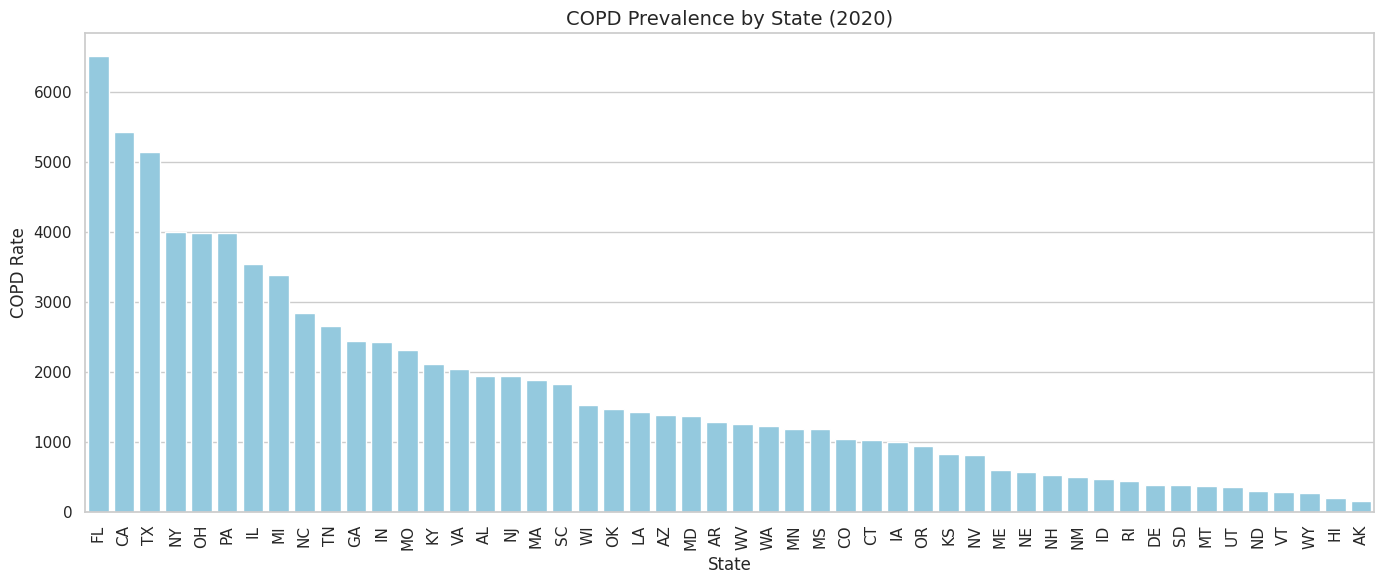

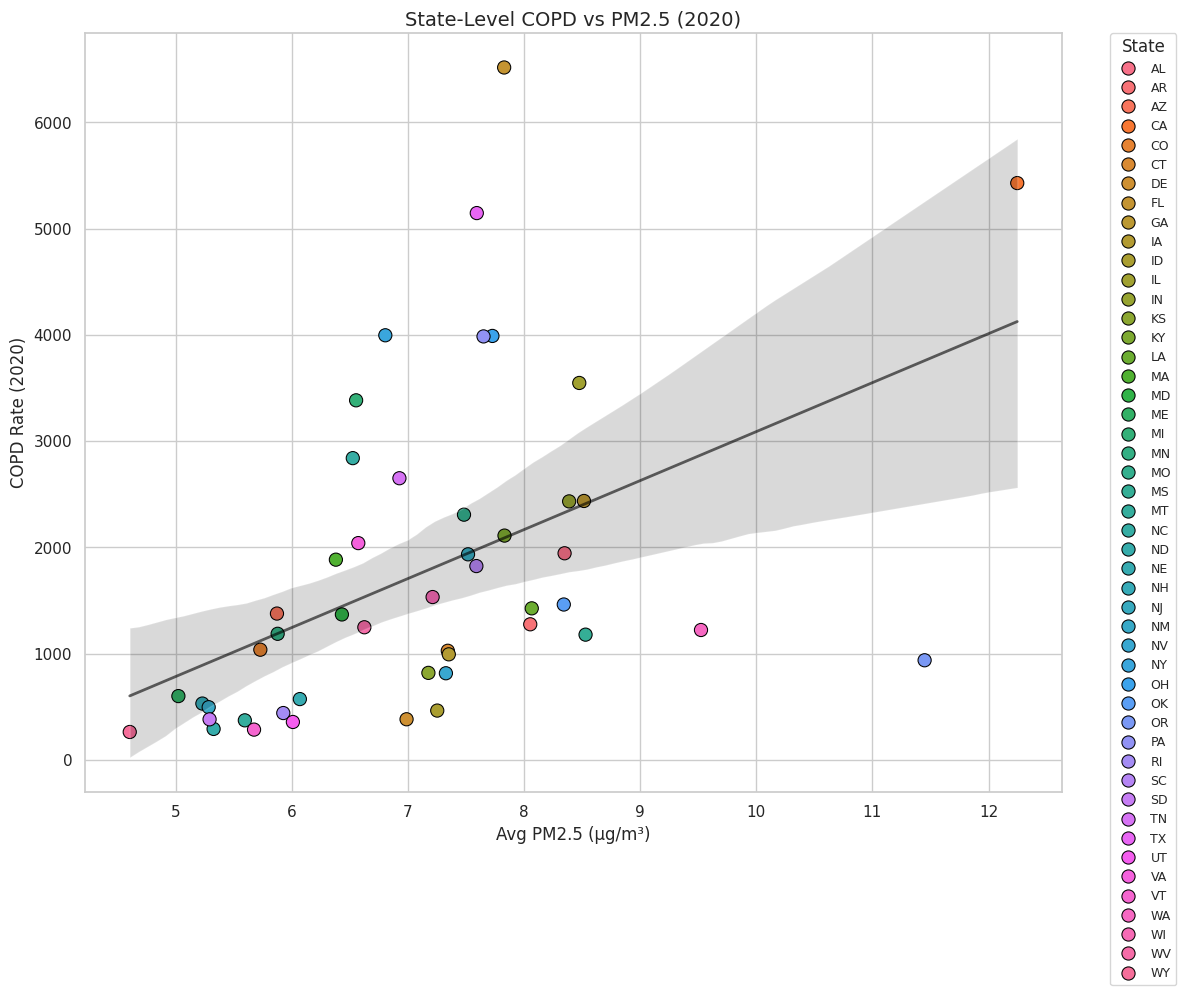


KEY OBSERVATIONS:

- COPD by State (Bar Chart):
   - COPD prevalence in 2020 varies significantly across states, with some states experiencing extremely high rates compared to the national distribution.
   - Florida, California, and Texas show noticeably higher COPD rates than most states, consistent with patterns often seen in larger, more populated regions.
   - Several states, especially many in the Northeast and upper Midwest, cluster toward the lower end of the distribution.
   - The wide spread in COPD rates highlights substantial state-level heterogeneity, which is important for any downstream hierarchical modeling.

- COPD vs PM2.5 Scatter Plot:
   - Each state is represented by one point, and using unique colors helps visualize the spread without overwhelming the plot.
   - There is a positive upward trend: states with higher PM2.5 levels tend to have higher COPD prevalence.
   - However, the association is not perfectly linear—several states with moderate PM2.5 have high COP

In [ ]:
# COPD BY STATE + COPD VS PM2.5 (2020 ONLY)

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)


print("EXPLORATORY DATA ANALYSIS (DIYA): COPD & PM2.5 — 2020")


# FETCH COPD PREVALENCE DATA (CDI API)

def fetch_copd_state_2020():
    url = "https://data.cdc.gov/resource/hksd-2xuw.json"
    params = {
        "$limit": 50000,
        "topic": "Chronic Obstructive Pulmonary Disease",
        "yearstart": 2020
    }

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())

    # Keep only relevant columns
    df["datavalue"] = pd.to_numeric(df["datavalue"], errors="coerce")
    df = df.dropna(subset=["datavalue"])

    # Remove non-state rows
    df = df[df["locationabbr"] != "US"]
    df = df[df["locationabbr"] != "PR"]
    df = df[df["locationabbr"] != "GU"]
    df = df[df["locationabbr"] != "DC"]

    # Aggregate per state
    df_copd = df.groupby(["locationabbr", "locationdesc"], as_index=False)["datavalue"].mean()

    df_copd = df_copd.rename(columns={
        "locationabbr": "state_abbr",
        "locationdesc": "state_name",
        "datavalue": "copd_rate_2020"
    })

    return df_copd

df_copd = fetch_copd_state_2020()

# LOAD PM2.5 (2020) FROM UPLOADED FILE

pm_file = "/PM2.5_Concentrations2020_perstate.csv"

df_pm = pd.read_csv(pm_file)

df_pm["statefips"] = pd.to_numeric(df_pm["statefips"], errors="coerce")
df_pm["avg_ds_pm_pred"] = pd.to_numeric(df_pm["avg_ds_pm_pred"], errors="coerce")

# MAP FIPS TO STATE ABBREVIATIONS

state_fips_lookup = {
    1:"AL",2:"AK",4:"AZ",5:"AR",6:"CA",8:"CO",9:"CT",10:"DE",11:"DC",
    12:"FL",13:"GA",15:"HI",16:"ID",17:"IL",18:"IN",19:"IA",20:"KS",
    21:"KY",22:"LA",23:"ME",24:"MD",25:"MA",26:"MI",27:"MN",28:"MS",
    29:"MO",30:"MT",31:"NE",32:"NV",33:"NH",34:"NJ",35:"NM",36:"NY",
    37:"NC",38:"ND",39:"OH",40:"OK",41:"OR",42:"PA",44:"RI",45:"SC",
    46:"SD",47:"TN",48:"TX",49:"UT",50:"VT",51:"VA",53:"WA",54:"WV",
    55:"WI",56:"WY"
}

df_pm["state_abbr"] = df_pm["statefips"].map(state_fips_lookup)


# MERGE COPD + PM2.5 (2020)

df_pm_state = df_pm.groupby("state_abbr", as_index=False)["avg_ds_pm_pred"].mean()
df_pm_state.rename(columns={"avg_ds_pm_pred": "pm25_mean_2020"}, inplace=True)

df_merged = df_copd.merge(df_pm_state, on="state_abbr", how="inner")

# PLOTS

# COPD by State
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_copd.sort_values("copd_rate_2020", ascending=False),
    x="state_abbr", y="copd_rate_2020", color="skyblue"
)
plt.xticks(rotation=90)
plt.title("COPD Prevalence by State (2020)", fontsize=14)
plt.ylabel("COPD Rate")
plt.xlabel("State")
plt.tight_layout()
plt.show()

# COPD vs PM2.5
plt.figure(figsize=(12,10))

# Scatter plot with each state → unique color
sns.scatterplot(
    data=df_merged,
    x="pm25_mean_2020",
    y="copd_rate_2020",
    hue="state_abbr",
    s=90,
    edgecolor="black"
)

# Optional regression line (single trend)
sns.regplot(
    data=df_merged,
    x="pm25_mean_2020",
    y="copd_rate_2020",
    scatter=False,
    color="black",
    line_kws={"linewidth":2, "alpha":0.6}
)

plt.title("State-Level COPD vs PM2.5 (2020)", fontsize=14)
plt.xlabel("Avg PM2.5 (μg/m³)")
plt.ylabel("COPD Rate (2020)")

# Move legend outside plot
plt.legend(
    title="State",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0,
    fontsize=9
)

plt.tight_layout()
plt.show()

df_merged["combined_rank"] = df_merged["copd_rate_2020"].rank() + df_merged["pm25_mean_2020"].rank()
df_merged.nsmallest(5, "combined_rank")

print("""
KEY OBSERVATIONS:

- COPD by State (Bar Chart):
   - COPD prevalence in 2020 varies significantly across states, with some states experiencing extremely high rates compared to the national distribution.
   - Florida, California, and Texas show noticeably higher COPD rates than most states, consistent with patterns often seen in larger, more populated regions.
   - Several states, especially many in the Northeast and upper Midwest, cluster toward the lower end of the distribution.
   - The wide spread in COPD rates highlights substantial state-level heterogeneity, which is important for any downstream hierarchical modeling.

- COPD vs PM2.5 Scatter Plot:
   - Each state is represented by one point, and using unique colors helps visualize the spread without overwhelming the plot.
   - There is a positive upward trend: states with higher PM2.5 levels tend to have higher COPD prevalence.
   - However, the association is not perfectly linear—several states with moderate PM2.5 have high COPD rates, suggesting additional factors contribute (e.g., smoking rates, age structure, occupational exposure).
   - A few states appear as potential outliers:
       - A state with high COPD but moderate PM2.5.
       - A state with very high PM2.5 but only moderate COPD.
   - These outliers can be important sensitivity checks when modeling or conducting causal inference later.

RELEVANCE TO RESEARCH QUESTIONS:

- RQ1: How do COPD prevalence rates vary across different U.S. states and demographic subgroups?
   - The bar chart directly shows substantial state-level variation, suggesting hierarchical modeling is appropriate because each state has its own underlying distribution.
   - Differences in COPD prevalence may reflect demographic, socioeconomic, or environmental structures—connecting with other team members’ analyses (e.g., ethnicity, age, smoking).
   - Visualizing COPD vs PM2.5 provides early evidence of environmental influences that might partially explain inter-state variation.

- RQ2: Does long term exposure to elevated PM2.5 concentrations causally increase COPD incidence rates?
   - The scatter plot offers preliminary descriptive evidence that higher PM2.5 correlates with higher COPD prevalence.
   - The positive trend suggests a potential causal link worth testing, but the presence of outliers indicates that PM2.5 alone is not sufficient to explain COPD variation.
   - This EDA helps motivate a more rigorous causal structure (eg. DAG, adjustment set) by showing which states fall where along the PM2.5-COPD spectrum.

NEXT STEPS FOR ANALYSIS:

- Consider including additional covariates (eg. smoking prevalence, income, age structure) to explain outliers and refine causal interpretation.
- Expand analysis to multiple years (2019–2020 or more) if additional PM2.5 files become available, to observe temporal stability or change.
- Combine COPD prevalence with demographic subgroup analysis (aligning with Jennifer’s ethnicity results and Albert’s smoking data).
- Identify clusters of states with similar air quality profiles to examine whether COPD behaves similarly within those clusters.
- Explore whether extremely high PM2.5 states remain consistent across years which is important for assessing chronic vs short term exposure effects.
""")

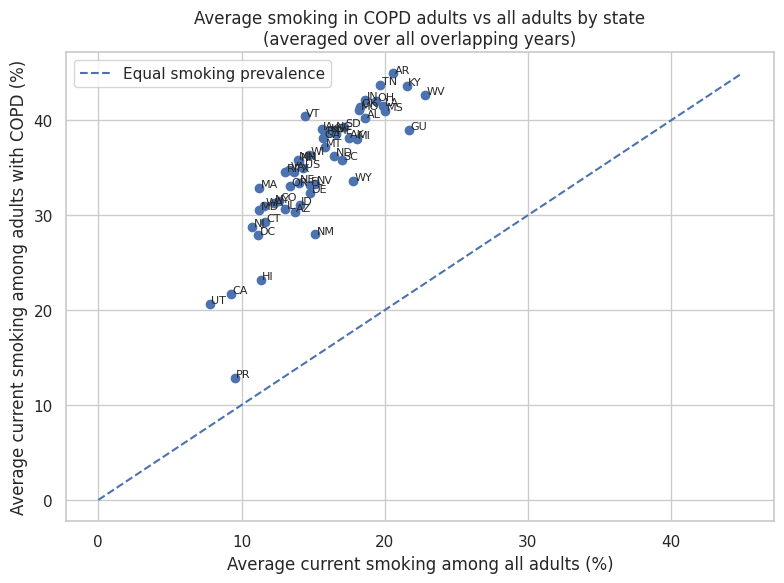


=== EDA Commentary for This Figure ===


2) Trends and relationships observed:
   - There is a strong positive association between overall smoking and
     smoking among COPD adults across states (correlation ≈ 0.86).
   - Almost all points lie above the 45-degree line, meaning adults with COPD
     tend to smoke at higher rates than the general adult population in the
     same state.

3) Relevance to our research questions:
   - For Research Question 1 (state-level variation in COPD and its drivers),
     this figure shows that smoking behavior among COPD patients is not
     independent of overall state smoking culture; states with high baseline
     smoking also have higher smoking among COPD adults.
   - For Research Question 2 (causal impact of PM2.5 on COPD after controlling
     for behavioral confounders), this plot highlights why smoking must be
     treated as an important confounder: COPD risk is intertwined with
     tobacco use, and smoking patterns vary systematically a

In [ ]:

# Styling
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# 1. Load COPD + Tobacco data from CDC API
base_url = "https://data.cdc.gov/resource/hksd-2xuw.json"
params = {
    "$limit": 100000,
    "$where": "topic in ('Chronic Obstructive Pulmonary Disease','Tobacco')"
}

response = requests.get(base_url, params=params)
response.raise_for_status()
df = pd.DataFrame(response.json())

# Make sure year is numeric
df["yearstart"] = pd.to_numeric(df["yearstart"], errors="coerce")

# 2. Define masks for the two indicators we need (all years)

# Overall current cigarette smoking among adults
smoke_mask = (
    (df["topic"] == "Tobacco") &
    (df["question"] == "Current cigarette smoking among adults") &
    (df["stratification1"] == "Overall") &
    (df["datavaluetype"] == "Crude Prevalence")
)

# Current smoking among adults WITH COPD
copd_smoking_mask = (
    df["question"].str.contains(
        "Current smoking among adults with chronic obstructive pulmonary disease",
        case=False,
        na=False
    ) &
    (df["stratification1"] == "Overall") &
    (df["datavaluetype"] == "Crude Prevalence")
)

# 3. Build state-year data and average over years

smoking_all = df[smoke_mask].copy()
smoking_all["datavalue"] = pd.to_numeric(smoking_all["datavalue"], errors="coerce")
smoking_all = smoking_all.rename(columns={"datavalue": "smoking_all_pct"})

copd_smoking = df[copd_smoking_mask].copy()
copd_smoking["datavalue"] = pd.to_numeric(copd_smoking["datavalue"], errors="coerce")
copd_smoking = copd_smoking.rename(columns={"datavalue": "copd_smoke_pct"})

merged_yearly = pd.merge(
    smoking_all[["locationabbr", "locationdesc", "yearstart", "smoking_all_pct"]],
    copd_smoking[["locationabbr", "yearstart", "copd_smoke_pct"]],
    on=["locationabbr", "yearstart"],
    how="inner"
).dropna(subset=["smoking_all_pct", "copd_smoke_pct"])

state_avg = (
    merged_yearly
    .groupby("locationabbr")
    .agg(
        locationdesc=("locationdesc", "first"),
        smoking_all_pct_avg=("smoking_all_pct", "mean"),
        copd_smoke_pct_avg=("copd_smoke_pct", "mean"),
    )
    .reset_index()
)

# 4. Plot: Average smoking in COPD adults vs all adults by state

plt.figure()
plt.scatter(
    state_avg["smoking_all_pct_avg"],
    state_avg["copd_smoke_pct_avg"]
)

for _, row in state_avg.iterrows():
    plt.text(
        row["smoking_all_pct_avg"] + 0.1,
        row["copd_smoke_pct_avg"] + 0.1,
        row["locationabbr"],
        fontsize=8
    )

max_val = max(
    state_avg["smoking_all_pct_avg"].max(),
    state_avg["copd_smoke_pct_avg"].max()
)
plt.plot([0, max_val], [0, max_val], linestyle="--", label="Equal smoking prevalence")

plt.xlabel("Average current smoking among all adults (%)")
plt.ylabel("Average current smoking among adults with COPD (%)")
plt.title("Average smoking in COPD adults vs all adults by state\n(averaged over all overlapping years)")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Printed EDA commentary for section 2.4

corr = state_avg["smoking_all_pct_avg"].corr(state_avg["copd_smoke_pct_avg"])

print("\n=== EDA Commentary for This Figure ===\n")
print()
print("2) Trends and relationships observed:")
print(f"   - There is a strong positive association between overall smoking and")
print(f"     smoking among COPD adults across states (correlation ≈ {corr:.2f}).")
print("""   - Almost all points lie above the 45-degree line, meaning adults with COPD
     tend to smoke at higher rates than the general adult population in the
     same state.

3) Relevance to our research questions:
   - For Research Question 1 (state-level variation in COPD and its drivers),
     this figure shows that smoking behavior among COPD patients is not
     independent of overall state smoking culture; states with high baseline
     smoking also have higher smoking among COPD adults.
   - For Research Question 2 (causal impact of PM2.5 on COPD after controlling
     for behavioral confounders), this plot highlights why smoking must be
     treated as an important confounder: COPD risk is intertwined with
     tobacco use, and smoking patterns vary systematically across states.

4) How this connects to later analyses:
   - This EDA step characterizes the behavioral environment around COPD.
     In later sections, we will combine these smoking patterns with
     state-level tobacco control policies and long-term PM2.5 exposure to
     test whether stricter policies and cleaner air are associated with
     lower COPD prevalence after adjusting for socio-demographics and
     baseline smoking behavior.
""")


***Checkpoint 2***